# Import Packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')



In [2]:
from google.colab import files
!pip install kaggle

In [4]:

!mkdir .kaggle
!touch .kaggle/kaggle.json
!mv .kaggle /root/


#upload kaggle json file

uploaded = files.upload()


mv: cannot move '.kaggle' to '/root/.kaggle': Directory not empty


Saving kaggle.json to kaggle.json


In [5]:
api_token = {"username":"geewynn","key":"b5dd5e9253a91c876fe288606e440250"}

import json
import zipfile

import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')


In [6]:
!kaggle datasets download -d wordsforthewise/lending-club

!unzip '/content/lending-club.zip'

 99% 1.25G/1.26G [00:09<00:00, 121MB/s]
100% 1.26G/1.26G [00:09<00:00, 141MB/s]
Archive:  /content/lending-club.zip
  inflating: accepted_2007_to_2018Q4.csv.gz  
  inflating: accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv  
  inflating: rejected_2007_to_2018Q4.csv.gz  
  inflating: rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv  


# Data Processing

In [0]:
accepted = pd.read_csv('/content/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

- Drop missing values and columns

In [0]:
# check the missing value
missing = accepted.isna().mean() *100

#select columns with less than 30% of its data missing
new_df =accepted.loc[:, accepted.isnull().mean() < .30]


#drop all rows with NaN. DUe to the large number of data se have. This will hel reduce computation cost
new_df =new_df.dropna()


#all our columns are uniform
#new_df.info()

- Get the numeric columns.
- We can only perfrom PCA on numeric columns

In [9]:
numeric_cols = new_df.select_dtypes(include=['int', 'float'])
numeric_cols.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,122.67,564.0,560.0,0.0,1.0,0.0,722.0,144904.0,9300.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0
1,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,926.35,699.0,695.0,0.0,1.0,0.0,0.0,204396.0,111800.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0
4,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,0.0,0.0,11740.500000,11740.50,10400.0,1340.50,0.0,0.0,0.0,10128.96,704.0,700.0,0.0,1.0,0.0,0.0,331730.0,34000.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0
6,20000.0,20000.0,20000.0,9.17,637.58,180000.0,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,0.0,0.0,21393.800000,21393.80,20000.0,1393.80,0.0,0.0,0.0,15681.05,654.0,650.0,0.0,1.0,0.0,0.0,360358.0,94200.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0
7,20000.0,20000.0,20000.0,8.49,631.26,85000.0,17.61,1.0,705.0,709.0,0.0,8.0,0.0,826.0,5.7,15.0,0.0,0.0,21538.508977,21538.51,20000.0,1538.51,0.0,0.0,0.0,14618.23,674.0,670.0,0.0,1.0,0.0,0.0,141601.0,14500.0,4.0,17700.0,13674.0,5.7,0.0,0.0,149.0,55.0,32.0,13.0,3.0,32.0,8.0,1.0,2.0,2.0,3.0,3.0,9.0,3.0,3.0,2.0,8.0,0.0,0.0,1.0,0.0,93.3,0.0,0.0,0.0,193390.0,27937.0,14500.0,36144.0


In [10]:
numeric_cols.shape

(1652452, 69)

- Check the cardinalty of each features

In [11]:
#obj_col = new_df.select_dtypes(include='object').columns.values
numeric_cols.nunique().sort_values()

policy_code               1
num_tl_30dpd              5
num_tl_120dpd_2m          7
acc_now_delinq            9
inq_last_6mths            9
                     ...   
tot_hi_cred_lim      494907
total_rec_int        567295
last_pymnt_amnt      580682
total_pymnt_inv     1055634
total_pymnt         1243070
Length: 69, dtype: int64

- Drop polcy code because it has one unique features

In [0]:
numeric_cols.drop(columns=['policy_code'], inplace=True)

In [13]:
numeric_cols.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06,1.652452e+06
mean,1.540056e+04,1.540055e+04,1.539534e+04,1.320688e+01,4.553241e+02,8.155162e+04,1.907115e+01,3.146893e-01,6.978323e+02,7.018324e+02,6.102495e-01,1.219905e+01,2.050728e-01,1.663544e+04,4.954003e+01,2.534225e+01,4.268253e+03,4.267331e+03,1.242488e+04,1.242020e+04,9.764168e+03,2.507770e+03,1.567891e+00,1.513775e+02,2.546086e+01,3.662239e+03,6.867745e+02,6.749240e+02,1.775422e-02,4.366844e-03,2.478876e+02,1.527296e+05,3.507346e+04,4.896144e+00,1.401778e+04,1.180043e+04,5.714297e+01,8.535800e-03,1.147379e+01,1.256754e+02,1.760307e+02,1.272503e+01,7.206243e+00,1.624873e+00,2.324261e+01,7.075988e+00,5.426378e-01,3.711316e+00,5.658028e+00,4.797886e+00,7.904594e+00,9.111594e+00,8.500482e+00,1.434485e+01,5.677195e+00,1.217264e+01,6.493381e-04,2.866649e-03,7.906856e-02,2.232668e+00,9.418519e+01,4.140471e+01,1.315966e-01,4.999237e-02,1.896348e+05,5.493539e+04,2.359013e+04,4.793943e+04
std,9.234003e+03,9.234004e+03,9.231835e+03,4.862807e+00,2.684328e+02,1.160033e+05,1.139126e+01,8.745538e-01,3.234255e+01,3.234307e+01,8.658819e-01,5.702190e+00,5.900406e-01,2.196154e+04,2.422334e+01,1.206885e+01,7.418910e+03,7.417985e+03,1.003501e+04,1.003126e+04,8.452689e+03,2.737463e+03,1.220794e+01,7.706769e+02,1.351041e+02,6.242972e+03,7.235826e+01,1.095817e+02,1.454091e-01,7.166378e-02,9.741305e+03,1.631568e+05,3.598724e+04,3.159250e+00,1.612684e+04,1.695254e+04,2.845025e+01,1.037894e-01,6.622900e+02,5.309062e+01,9.192502e+01,1.549664e+01,6.863551e+00,1.926746e+00,2.993179e+01,5.961772e+00,1.412692e+00,2.270365e+00,3.284417e+00,2.890194e+00,4.717221e+00,7.511557e+00,4.729983e+00,8.071656e+00,3.293245e+00,5.698628e+00,2.748500e-02,5.661975e-02,4.785450e-01,1.842617e+00,8.841346e+00,3.583868e+01,3.721152e-01,3.960866e-01,1.835351e+05,5.139474e+04,2.302040e+04,4.621438e+04
min,1.000000e+03,1.000000e+03,7.250000e+02,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.600000e+02,6.640000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,-9.500000e-09

- Plot the correlaton matrix for each features.

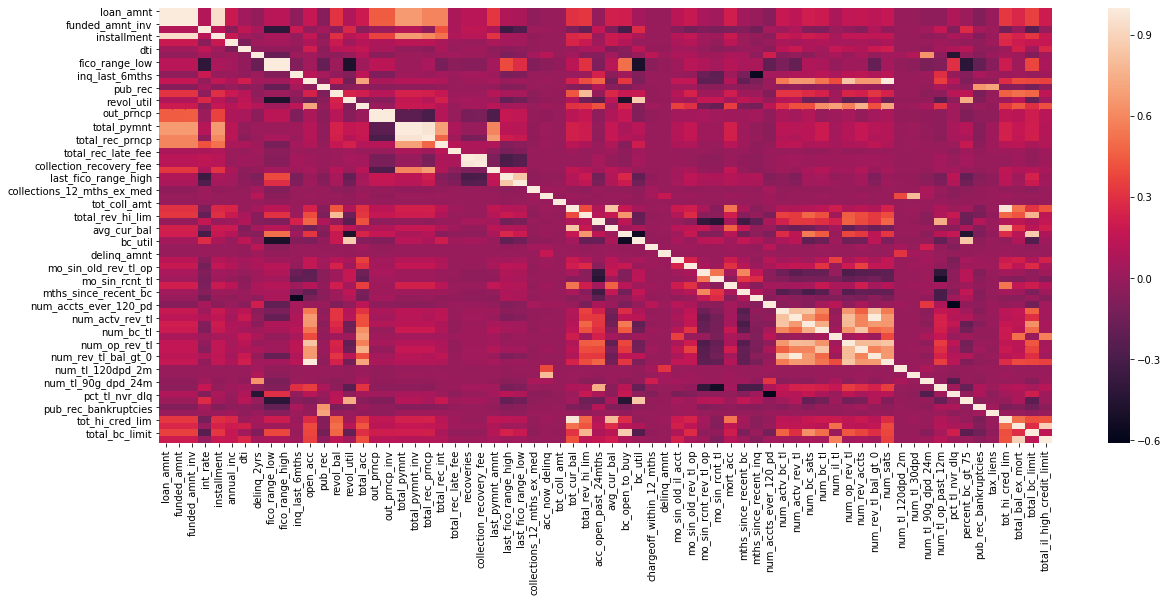

In [14]:
corr = numeric_cols.corr()

plt.figure(figsize=(20,8))
sns.heatmap(corr)

- Scale the features so PCA will perform better and also to make sure it doesn't skew towards the outliers in the dataset.
- Check the mean of each scaled features.

In [15]:
scaled = StandardScaler().fit_transform(numeric_cols.values)
scaled.mean(axis=0).round(2)

array([ 0., -0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0., -0.,  0., -0.,
        0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,
        0., -0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0., -0., -0.,
       -0., -0.,  0.])

In [16]:
# Store Scaled values in a DataFrame 
standard_df = pd.DataFrame(scaled, columns = numeric_cols.columns)
standard_df.describe().round(2)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00,1652452.00
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.56,-1.56,-1.59,-1.62,-1.68,-0.70,-1.76,-0.36,-1.17,-1.17,-0.70,-1.96,-0.35,-0.76,-2.05,-1.85,-0.58,-0.58,-1.24,-1.24,-1.16,-0.92,-0.13,-0.20,-0.19,-0.59,-9.49,-6.16,-0.12,-0.06,-0.03,-0.94,-0.97,-1.55,-0.87,-0.70,-2.01,-0.08,-0.02,-2.37,-1.90,-0.82,-1.05,-0.84,-0.78,-1.19,-0.38,-1.63,-1.72,-1.66,-1.46,-1.08,-1.59,-1.65,-1.72,-1.96,-0.02,-0.05,-0.17,-1.21,-10.65,-1.16,-0.35,-0.13,-1.03,-1.07,-1.02,-1.04
25%,-0.80,-0.80,-0.80,-0.72,-0.73,-0.27,-0.58,-0.36,-0.71,-0.71,-0.70,-0.74,-0.35,-0.48,-0.76,-0.69,-0.58,-0.58,-0.76,-0.76,-0.79,-0.64,-0.13,-0.20,-0.19,-0.54,-0.45,-0.23,-0.12,-0.06,-0.03,-0.73,-0.55,-0.60,-0.66,-0.59,-0.79,-0.08,-0.02,-0.56,-0.66,-0.56,-0.61,-0.84,-0.58,-0.85,-0.38,-0.75,-0.81,-0.62,-0.62,-0.68,-0.74,-0.66,-0.81,-0.73,-0.02,-0.05,-0.17,-0.67,-0.28,-1.16,-0.35,-0.13,-0.72,-0.60,-0.65,-0.63
50%,-0.18,-0.18,-0.18,-0.11,-0.25,-0.10,-0.07,-0.36,-0.24,-0.24,-0.70,-0.21,-0.35,-0.23,-0.01,-0.11,-0.58,-0.58,-0.27,-0.27,-0.30,-0.34,-0.13,-0.20,-0.19,-0.49,0.17,0.18,-0.12,-0.06,-0.03,-0.36,-0.25,-0.28,-0.36,-0.36,0.07,-0.08,-0.02,0.08,-0.17,-0.30,-0.32,-0.32,-0.34,-0.18,-0.38,-0.31,-0.20,-0.28,-0.19,-0.28,-0.11,-0.17,-0.21,-0.21,-0.02,-0.05,-0.17,-0.13,0.44,-0.23,-0.35,-0.13,-0.33,-0.27,-0.30,-0.25
75%,0.50,0.50,0.50,0.58,0.56,0.13,0.50,-0.36,0.53,0.53,0.45,0.49,-0.35,0.17,0.76,0.55,0.27,0.27,0.50,0.50,0.54,0.26,-0.13,-0.20,-0.19,0.11,0.65,0.50,-0.12,-0.06,-0.03,0.46,0.25,0.35,0.34,0.18,0.88,-0.08,-0.02,0.51,0.52,0.21,0.41,0.71,0.16,0.66,-0.38,0.57,0.41,0.42,0

# PCA

- Create PCA with a component of 7
- Fit the PCA on the scaled dataframe

In [17]:
# Create PCA
pca = PCA(n_components=7, random_state=42)

# fit the data to the model
principalComponents = pca.fit_transform(scaled)

principalComponents.shape

(1652452, 7)

In [0]:
# # create dataframe containing principal components
# principal_cols = ['principal component 1', 'principal component 2','principal component 3',
#                   'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10']
# principalDf = pd.DataFrame(data = principalComponents, columns = principal_cols)

# # display top 5 principal components
# principalDf.head()

- Check the explained variance of each principal components.

In [19]:
# Print the total variance explained by the first 7 principal components 
pca.explained_variance_ratio_

array([0.15595266, 0.09512713, 0.07731733, 0.05341456, 0.04749775,
       0.04358161, 0.03626273])

- Check the sum of the explaned variance.

In [20]:
# Print the sum of the explained variance ratio
pca.explained_variance_ratio_.sum()

0.509153770775275

- Calculate the cumulative variance explained

In [21]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var1

array([15.6 , 25.11, 32.84, 38.18, 42.93, 47.29, 50.92])

- Plot the variance

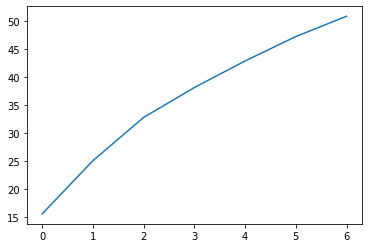

In [22]:
plt.plot(var1)

- Introduce Kmeans cluster.
- Kmeans will help us find the structure in the dataset.
- We use a cluster 3 here.
- Fit the Kmeans model on the new PCA components.

#KMeans

In [25]:
# declare a Kmeans instance with 3 classes
model = KMeans(n_clusters=3, init='k-means++', random_state=42)
# fit data 
clusters = model.fit_predict(principalComponents)
clusters

array([1, 2, 2, ..., 2, 2, 1], dtype=int32)

- Plot the CLusters.

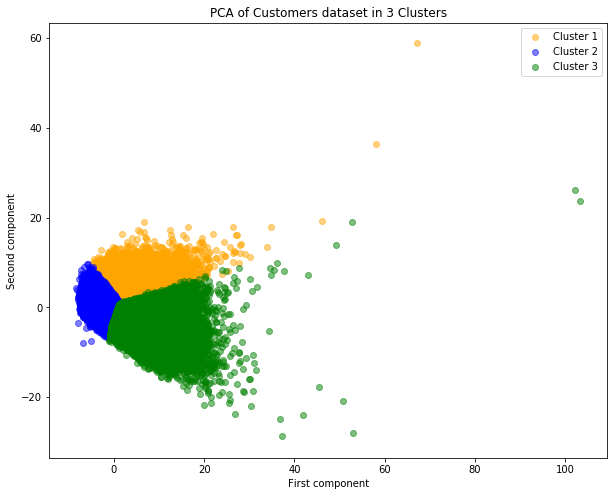

In [26]:
plt.figure(figsize = (10,8))

plt.scatter(principalComponents[clusters == 0, 0], principalComponents[clusters == 0, 1], alpha=.5, 
            color = 'orange', label='Cluster 1')

plt.scatter(principalComponents[clusters == 1, 0], principalComponents[clusters == 1, 1], alpha=.5, 
            color = 'blue', label='Cluster 2')

plt.scatter(principalComponents[clusters == 2, 0], principalComponents[clusters == 2, 1], alpha=.5, 
            color = 'green', label='Cluster 3')

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('PCA of Customers dataset in 3 Clusters');

- We can clearly see the 3 clusters n the scatterplot above.

- Plot the elbow plot to know the adequate number of clusters to use.

In [0]:
sse = {}
# Fit KMeans and calculate SSE for each k
for c in range(1, 10):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=c, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(principalComponents)
    
    # Assign sum of squared distances to k element of dictionary
    sse[c] = kmeans.inertia_

- From the plot below we can see the elbow is at 2

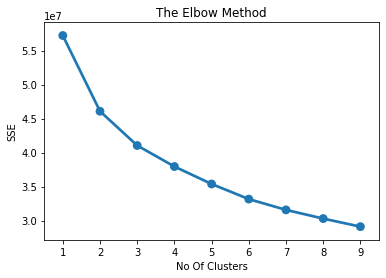

In [33]:
# Plot SSE for each *c*
plt.title('The Elbow Method')
plt.xlabel('No Of Clusters'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()